In [4]:
# Essentials:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

# imputation
from sklearn.impute import KNNImputer

# Scaling
from sklearn.preprocessing import StandardScaler

# PCA
from sklearn.decomposition import PCA

# K-means for Clustering
from sklearn.cluster import KMeans

# elbow method
from yellowbrick.cluster import KElbowVisualizer

# cluster metrics
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score

# Silhouette Visualizer
from yellowbrick.cluster import SilhouetteVisualizer

In [5]:
cc_general = pd.read_csv('CC GENERAL.csv')

In [6]:
cc_general.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


# Check for missing values:

In [7]:
cc_general.isna().sum()

CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

## Check for outliers:

Using IQR, we can follow the below approach to find outliers:

- Calculate the first and third quartile (Q1 and Q3).
- Further, evaluate the interquartile range, IQR = Q3-Q1.
- Estimate the lower bound, the lower bound = Q1*1.5
- Estimate the upper bound, upper bound = Q3*1.5
- The data points that lie outside of the lower and the upper bound are outliers.

In [8]:
def outlier_percent(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    minimum = Q1 - (1.5 * IQR)
    maximum = Q3 + (1.5 * IQR)
    num_outliers =  np.sum((data < minimum) |(data > maximum))
    num_total = data.count()
    return (num_outliers/num_total)*100

In [9]:
non_categorical_data = cc_general.drop(['CUST_ID'], axis=1)
for column in non_categorical_data.columns:
    data = non_categorical_data[column]
    percent = str(round(outlier_percent(data), 2))
    print(f'Outliers in "{column}": {percent}%')

Outliers in "BALANCE": 7.77%
Outliers in "BALANCE_FREQUENCY": 16.68%
Outliers in "PURCHASES": 9.03%
Outliers in "ONEOFF_PURCHASES": 11.32%
Outliers in "INSTALLMENTS_PURCHASES": 9.69%
Outliers in "CASH_ADVANCE": 11.51%
Outliers in "PURCHASES_FREQUENCY": 0.0%
Outliers in "ONEOFF_PURCHASES_FREQUENCY": 8.74%
Outliers in "PURCHASES_INSTALLMENTS_FREQUENCY": 0.0%
Outliers in "CASH_ADVANCE_FREQUENCY": 5.87%
Outliers in "CASH_ADVANCE_TRX": 8.98%
Outliers in "PURCHASES_TRX": 8.56%
Outliers in "CREDIT_LIMIT": 2.77%
Outliers in "PAYMENTS": 9.03%
Outliers in "MINIMUM_PAYMENTS": 9.74%
Outliers in "PRC_FULL_PAYMENT": 16.47%
Outliers in "TENURE": 15.26%


# Preprocessing
in this part, I'm going to:
1. remove the outliers
2. impute missing data
3. scale the data
4. Reduce dimentions using PCA

## Removing the outliers
first, let's get rid of the noise. we're going to first set all outliers as `NaN`, so it will be taken care of in the next stage, where we impute the missing values. 

In [11]:
for column in non_categorical_data.columns:
    data = non_categorical_data[column]
    
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    minimum = Q1 - (1.5 * IQR)
    maximum = Q3 + (1.5 * IQR)
 
    outliers = ((data < minimum) |(data > maximum))
    non_categorical_data[column].loc[outliers] = np.nan
    
non_categorical_data.isna().sum()

BALANCE                              695
BALANCE_FREQUENCY                   1493
PURCHASES                            808
ONEOFF_PURCHASES                    1013
INSTALLMENTS_PURCHASES               867
CASH_ADVANCE                        1030
PURCHASES_FREQUENCY                    0
ONEOFF_PURCHASES_FREQUENCY           782
PURCHASES_INSTALLMENTS_FREQUENCY       0
CASH_ADVANCE_FREQUENCY               525
CASH_ADVANCE_TRX                     804
PURCHASES_TRX                        766
CREDIT_LIMIT                         249
PAYMENTS                             808
MINIMUM_PAYMENTS                    1154
PRC_FULL_PAYMENT                    1474
TENURE                              1366
dtype: int64

## Imputing the missing data
I use `KNN imputer`: Each sample’s missing values are imputed using the mean value from n_neighbors nearest neighbors found in the training set.

In [12]:
imputer = KNNImputer()
imp_data = pd.DataFrame(imputer.fit_transform(non_categorical_data), columns=non_categorical_data.columns)
imp_data.isna().sum()

BALANCE                             0
BALANCE_FREQUENCY                   0
PURCHASES                           0
ONEOFF_PURCHASES                    0
INSTALLMENTS_PURCHASES              0
CASH_ADVANCE                        0
PURCHASES_FREQUENCY                 0
ONEOFF_PURCHASES_FREQUENCY          0
PURCHASES_INSTALLMENTS_FREQUENCY    0
CASH_ADVANCE_FREQUENCY              0
CASH_ADVANCE_TRX                    0
PURCHASES_TRX                       0
CREDIT_LIMIT                        0
PAYMENTS                            0
MINIMUM_PAYMENTS                    0
PRC_FULL_PAYMENT                    0
TENURE                              0
dtype: int64

## Scale the Data
I use `StandardScaler`

In [13]:
std_imp_data = pd.DataFrame(StandardScaler().fit_transform(imp_data), columns=imp_data.columns)
std_imp_data.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
count,8.950000e+03,8.950000e+03,8.950000e+03,8.950000e+03,8.950000e+03,8.950000e+03,8.950000e+03,8.950000e+03,8.950000e+03,8.950000e+03,8.950000e+03,8.950000e+03,8.950000e+03,8.950000e+03,8.950000e+03,8.950000e+03,8950.0
mean,1.459292e-16,3.641780e-15,-3.845664e-15,8.330072e-15,9.068103e-16,8.933760e-16,-3.716084e-16,-7.758809e-15,2.353921e-16,-9.233334e-16,-7.427330e-17,9.962980e-16,4.909878e-15,4.842805e-16,-2.008573e-16,-2.921344e-15,0.0
std,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,0.0
min,-9.711973e-01,-4.155613e+00,-9.108875e-01,-6.679045e-01,-7.876755e-01,-6.489418e-01,-1.221758e+00,-7.446281e-01,-9.169952e-01,-7.472686e-01,-6.819606e-01,-9.664084e-01,-1.365191e+00,-1.191542e+00,-1.158882e+00,-4.495377e-01,0.0
25%,-8.704482e-01,3.667368e-01,-8.520982e-01,-6.679045e-01,-7.876755e-01,-6.489418e-01,-1.014125e+00,-7.446281e-01,-9.169952e-01,-7.472686e-01,-6.819606e-01,-8.736091e-01,-8.652204e-01,-8.088997e-01,-7.803523e-01,-4.495377e-01,0.0
50%,-2.883274e-01,3.667368e-01,-3.757635e-01,-5.868463e-01,-4.754304e-01,-6.489418e-01,2.404259e-02,-3.780223e-01,-4.976286e-01,-7.472686e-01,-6.819606e-01,-3.168136e-01,-4.136338e-01,-3.375007e-01,-4.237788e-01,-4.495377e-01,0.0
75%,5.646491e-01,3.667368e-01,6.126365e-01,3.671317e-01,5.319986e-01,5.416827e-01,1.062211e+00,4.485112e-01,9.701506e-01,4.368733e-01,4.783950e-01,6.111790e-01,6.508204e-01,6.738027e-01,6.386496e-01,-2.118108e-01,0.0
max,2.911266e+00,3.667368e-01,3.120231e+00,3.512681e+00,3.318839e+00,3.337571e+00,1.269843e+00,2.554838e+00,1.599199e+00,3.128100e+00,3.185891e+00,2.838361e+00,3.005522e+00,2.978873e+00,2.852750e+00,4.305014e+00,0.0


## Dimention Reduction using PCA
K-means, DBSCAN and agglomerative clustering, all use the Euclidean distance, which starts to lose its meaning when the number of dimensions starts increasing. so, before using these methods, we have to reduce the number of dimensions. I'm going to use PCA, which is by far the most popular dimensionality reduction algorithm. 

***⚠ If you are not familiar with PCA or need to learn more about it, I highly recommend you read [my Notes](https://cookie-baboon-7d6.notion.site/PCA-0879e6e386b747c6881506bfdf0e9c61) on this dimentionality reduction method, In which I cover almost anything you need to know about this algorithm.***

here I set parameter `n_components` equals to 0.9, which means that the PCA will automatically produce enough PCs that will preserve 90% of variance in the dataset.

In [14]:
pca = PCA(n_components=0.9, random_state=42)
pca.fit(std_imp_data)
PC_names = ['PC'+str(x) for x in range(1,len(pca.components_)+1)]
pca_data = pd.DataFrame(pca.transform(std_imp_data), columns=PC_names)

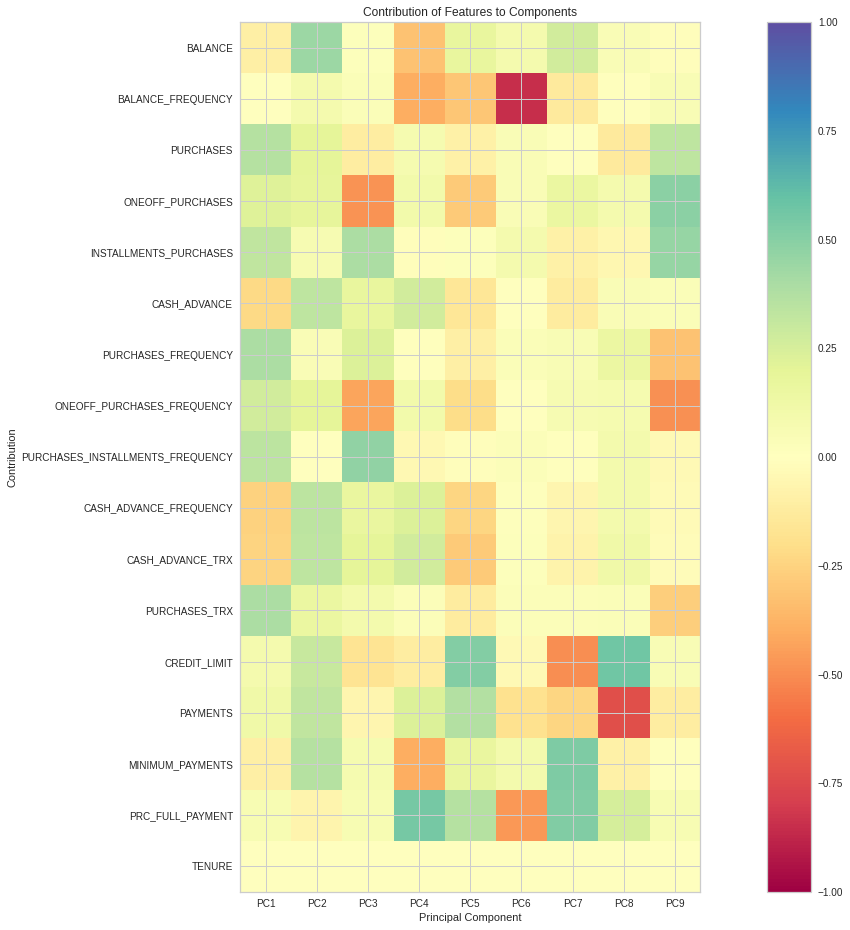

In [15]:
fig, ax = plt.subplots(figsize=(24, 16))
plt.imshow(pca.components_.T,
           cmap="Spectral",
           vmin=-1,
           vmax=1,
          )
plt.yticks(range(len(std_imp_data.columns)), std_imp_data.columns)
plt.xticks(range(len(pca_data.columns)), pca_data.columns)
plt.xlabel("Principal Component")
plt.ylabel("Contribution")
plt.title("Contribution of Features to Components")
plt.colorbar()

# Train the Model
now that we have done the preprocessing step, we can perform K-means clustering on our data. 

first, we have to find good parameters for our model.

## Find the `n_clusters` parameter using the elbow method

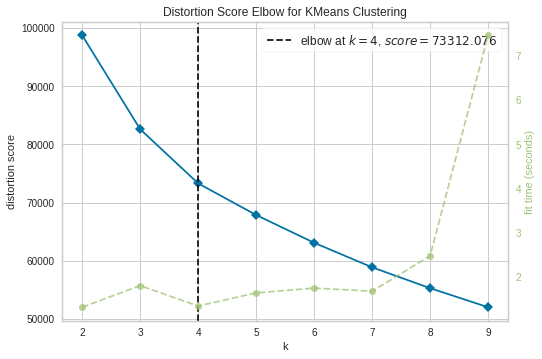

In [16]:
model = KMeans(random_state=42)
distortion_visualizer = KElbowVisualizer(model, k=(2,10))

distortion_visualizer.fit(pca_data)       
distortion_visualizer.show()       

In [17]:
km_model = KMeans(distortion_visualizer.elbow_value_, random_state=42)
labels = km_model.fit_predict(pca_data)

# Evaluate the Model
Let's see how good/bad is our model.

we start by caculating two metrics: 
- **The Davis-Bouldin Index** is the average similarity between each cluster and the closest cluster. Scores range from 0 and up. 0 indicates better clustering.
- **The Silhouette Coefficient** is a value between -1 and 1. The higher the score, the better. 1 indicates tight clusters, and 0 means overlapping clusters. 

In [18]:
print(f'Davies-Bouldin index = {davies_bouldin_score(pca_data, labels)}')
print(f'Silhouette Score = {silhouette_score(pca_data, labels)}')

Davies-Bouldin index = 1.553675096074755
Silhouette Score = 0.1989293328933083
